In [1]:
import importlib

import pandas as pd
from IPython.display import display

import warnings

import Semantic_Maningfullness

warnings.filterwarnings('ignore')

from carla.data.causal_model import CausalModel

/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


# TODOS

This Script still has following issues / todos: 
-  [ ] XXX

- [ ] Unify Naming !
- [ ] Why is Wachter prefect ? 

In [2]:
import numpy as np 
import torch
import random

#SEED Setting
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [3]:
import pandas as pd


# generate data
scm = CausalModel("sanity-3-lin")
dataset = scm.generate_dataset(10000, False)

# save data
# dataset.df.to_csv('generate_dataset.csv')

display(dataset.df)

3
fuzzy False
threshold (10000, 1)
predictions [[0.81547689]
 [0.29413994]
 [0.14887375]
 ...
 [0.01716335]
 [0.49883894]
 [0.21321965]]


label        x1        x2        x3
0       1.0 -3.822251  3.206103  1.394095
1       0.0 -0.125186 -0.267489 -0.065593
2       0.0  1.388819 -2.420645  0.119093
3       0.0 -0.173873 -0.715379 -1.201855
4       1.0 -0.637307  1.071684  0.379442
...     ...       ...       ...       ...
9995    0.0  0.971876 -0.067054 -1.317657
9996    1.0  1.792395 -2.272653  0.620624
9997    0.0  1.994518 -3.212899 -0.900646
9998    0.0 -2.854051  3.213437 -0.361817
9999    0.0 -2.368446  1.890917 -0.205989

[10000 rows x 4 columns]

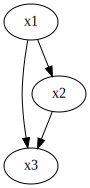

In [4]:
#Visualize the model
scm.cgm.draw()

In [5]:
from carla.models.catalog import MLModelCatalog

training_params = {"lr": 0.01, "epochs": 10, "batch_size": 16, "hidden_size": [18, 9, 3]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)



balance on test set 0.5169333333333334, balance on test set 0.5152
Epoch 0/9
----------
train Loss: 0.0725 Acc: 0.9716

test Loss: 0.0608 Acc: 0.9776

Epoch 1/9
----------
train Loss: 0.0371 Acc: 0.9853

test Loss: 0.0255 Acc: 0.9888

Epoch 2/9
----------
train Loss: 0.0342 Acc: 0.9872

test Loss: 0.0268 Acc: 0.9868

Epoch 3/9
----------
train Loss: 0.0322 Acc: 0.9869

test Loss: 0.0276 Acc: 0.9884

Epoch 4/9
----------
train Loss: 0.0299 Acc: 0.9888

test Loss: 0.0201 Acc: 0.9912

Epoch 5/9
----------
train Loss: 0.0285 Acc: 0.9891

test Loss: 0.0188 Acc: 0.9920

Epoch 6/9
----------
train Loss: 0.0271 Acc: 0.9897

test Loss: 0.0162 Acc: 0.9928

Epoch 7/9
----------
train Loss: 0.0279 Acc: 0.9897

test Loss: 0.0192 Acc: 0.9928

Epoch 8/9
----------
train Loss: 0.0267 Acc: 0.9895

test Loss: 0.0474 Acc: 0.9816

Epoch 9/9
----------
train Loss: 0.0241 Acc: 0.9899

test Loss: 0.0591 Acc: 0.9756



In [6]:
from carla.models.negative_instances import predict_negative_instances
# get factuals
factuals = dataset.df#predict_negative_instances(ml_model, dataset.df)
test_factual_with_labels = factuals.iloc[:10].reset_index(drop=True)
test_factual=test_factual_with_labels.copy()
print(test_factual)

   label        x1        x2        x3
0    1.0 -3.822251  3.206103  1.394095
1    0.0 -0.125186 -0.267489 -0.065593
2    0.0  1.388819 -2.420645  0.119093
3    0.0 -0.173873 -0.715379 -1.201855
4    1.0 -0.637307  1.071684  0.379442
5    0.0 -2.087104  2.218720 -0.248939
6    0.0 -1.895168  2.386755 -0.718443
7    0.0  0.721627 -0.507613 -0.951930
8    0.0  1.772848 -1.068509 -0.722962
9    1.0  1.783160 -0.904946  1.107616


In [7]:
'''Causal Recourse Model '''
from carla.recourse_methods.catalog.causal_recourse import (
    CausalRecourse,
    constraints,
    samplers,
)
hyperparams = {
    "optimization_approach": "brute_force",
    "num_samples": 10,
    "scm": scm,
    "constraint_handle": constraints.point_constraint,
    "sampler_handle": samplers.sample_true_m0,
}

#print(len(test_factual))
# structural counterfactual (SCF)
#cfs = CausalRecourse(ml_model, hyperparams).get_counterfactuals(test_factual)
recourse=CausalRecourse(ml_model, hyperparams)

In [8]:
scm_output=CausalModel("sanity-3-lin-output")

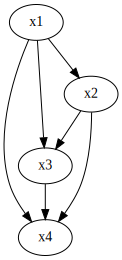

In [9]:
#Visualize the model
scm_output.cgm.draw()

In [10]:
import importlib
from Semantic_Maningfullness import Sematic
importlib.reload(Semantic_Maningfullness)

<module 'Semantic_Maningfullness' from '/media/jacqueline/Data/CARLA/Semantic_Maningfullness.py'>

In [11]:
'''Original Evaluation'''
from carla.data.catalog import CsvCatalog
from carla import Benchmark
mapping_dict={ 
      'u1': 'x1',
      'u2': 'x2',
    'u3': 'x3',
      }
# first initialize the benchmarking class by passing
# black-box-model, recourse method, and factuals into it
benchmark = Benchmark(ml_model, recourse, test_factual)

# now you can decide if you want to run all measurements
# or just specific ones.
evaluation_measures = [
    #evaluation_catalog.YNN(benchmark.mlmodel, {"y": 5, "cf_label": 1}),
    #evaluation_catalog.Distance(benchmark.mlmodel),
    #evaluation_catalog.SuccessRate(),
    #evaluation_catalog.Redundancy(benchmark.mlmodel, {"cf_label": 1}),
    #evaluation_catalog.ConstraintViolation(benchmark.mlmodel),
    #evaluation_catalog.AvgTime({"time": benchmark.timer}),
    Sematic(ml_model,scm_output,mapping_dict),    
]

# now run all implemented measurements and create a
# DataFrame which consists of all results
results = benchmark.run_benchmark(evaluation_measures)

display(results.head(5))

Action Set {'x1': -12.88998, 'x2': -13.71963, 'x3': -9.56649}
Original x1   -3.822251
x2    3.206103
x3    1.394095
Name: 0, dtype: float64
cf Inatance from Constraint          x1        x2       x3
0 -12.88998 -13.71963 -9.56649
prediction from DL Model [[0.]]
Returns [[False]]
Action Set {'x1': -12.88998, 'x2': -13.71963, 'x3': -7.48263}
Original x1   -3.822251
x2    3.206103
x3    1.394095
Name: 0, dtype: float64
cf Inatance from Constraint          x1        x2       x3
0 -12.88998 -13.71963 -7.48263
prediction from DL Model [[0.]]
Returns [[False]]
Action Set {'x1': -12.88998, 'x2': -13.71963, 'x3': -5.39877}
Original x1   -3.822251
x2    3.206103
x3    1.394095
Name: 0, dtype: float64
cf Inatance from Constraint          x1        x2       x3
0 -12.88998 -13.71963 -5.39877
prediction from DL Model [[0.]]
Returns [[False]]
Action Set {'x1': -12.88998, 'x2': -13.71963, 'x3': -3.31491}
Original x1   -3.822251
x2    3.206103
x3    1.394095
Name: 0, dtype: float64
cf Inatance from Con

semantic
0         1
1         1
2         1
3         0
4         1

In [12]:
dataset.df.to_csv('temp.csv',index=False)

In [13]:
#TODO needs to run twice to get results --> why?

import carla.evaluation.catalog as evaluation_catalog
from carla.data.catalog import CsvCatalog
from carla import Benchmark
mapping_dict={ 
      'u1': 'x1',
      'u2': 'x2',
    'u3': 'x3',
      }
# first initialize the benchmarking class by passing
# black-box-model, recourse method, and factuals into it

#Build dataset Compatible with wachter: 


# Build Dataset usable with Wachter
import pandas as pd
# Load Data 

dataframe_wachter = pd.read_csv('temp.csv')
continuous_wachter = dataframe_wachter.drop(columns=['label']).columns

dataset_wachter = CsvCatalog(file_path="temp.csv",
                     continuous=continuous_wachter,
                     categorical=[],
                     immutables=[],
                     target='label',
                     scaling_method='Identity')

#TODO unforunatly need to retrain model, due to dataset / implmentation --> Does not learn anything
from carla.models.catalog import MLModelCatalog

training_params = {"lr": 0.01, "epochs": 10, "batch_size": 16, "hidden_size": [18, 9, 3]}


ml_model_wachter = MLModelCatalog(
    dataset_wachter, model_type="ann", load_online=False, backend="pytorch"
)
ml_model_wachter.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)
#TODO dont use negative instances ? 
factuals_wachter = predict_negative_instances(ml_model_wachter, dataset_wachter.df)
test_factual_with_labels_wachter = factuals[0:30].reset_index(drop=True)
test_factual_wachter=test_factual_with_labels_wachter.copy()
print(len(test_factual_wachter))
'''Wachter Recourse'''
import carla.recourse_methods.catalog as recourse_catalog
hyperparams = {"loss_type": "BCE"}

recourse_wachter =  recourse_catalog.wachter.model.Wachter(ml_model_wachter, hyperparams)

benchmark_wachter = Benchmark(ml_model_wachter, recourse_wachter, test_factual_wachter)

# now you can decide if you want to run all measurements
# or just specific ones.
evaluation_measures_wachter = [
    #evaluation_catalog.YNN(benchmark.mlmodel, {"y": 5, "cf_label": 1}),
    #evaluation_catalog.Distance(benchmark.mlmodel),
    #evaluation_catalog.SuccessRate(),
    #evaluation_catalog.Redundancy(benchmark.mlmodel, {"cf_label": 1}),
    #evaluation_catalog.ConstraintViolation(benchmark_wachter.mlmodel),
    #evaluation_catalog.AvgTime({"time": benchmark_wachter.timer}),
    Sematic(ml_model_wachter,scm_output,mapping_dict),    
]

# now run all implemented measurements and create a
# DataFrame which consists of all results
results_wachter = benchmark_wachter.run_benchmark(evaluation_measures_wachter)

display(results_wachter.head(5))



     


balance on test set 0.5117333333333334, balance on test set 0.5308
Epoch 0/9
----------
train Loss: 0.0679 Acc: 0.9713

test Loss: 0.0361 Acc: 0.9852

Epoch 1/9
----------
train Loss: 0.0370 Acc: 0.9860

test Loss: 0.0350 Acc: 0.9844

Epoch 2/9
----------
train Loss: 0.0326 Acc: 0.9877

test Loss: 0.0409 Acc: 0.9836

Epoch 3/9
----------
train Loss: 0.0294 Acc: 0.9901

test Loss: 0.0157 Acc: 0.9928

Epoch 4/9
----------
train Loss: 0.0301 Acc: 0.9875

test Loss: 0.0814 Acc: 0.9740

Epoch 5/9
----------
train Loss: 0.0300 Acc: 0.9876

test Loss: 0.0322 Acc: 0.9848

Epoch 6/9
----------
train Loss: 0.0292 Acc: 0.9881

test Loss: 0.0368 Acc: 0.9864

Epoch 7/9
----------
train Loss: 0.0271 Acc: 0.9893

test Loss: 0.0400 Acc: 0.9808

Epoch 8/9
----------
train Loss: 0.0276 Acc: 0.9891

test Loss: 0.0295 Acc: 0.9876

Epoch 9/9
----------
train Loss: 0.0267 Acc: 0.9892

test Loss: 0.0150 Acc: 0.9924

30
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactua

semantic
0         1
1         1
2         1
3         1
4         1

In [14]:
# Averaging of the reults
# In  one case the DL Model and SCM Model are consistently wrong !
mean= np.mean(results['semantic'])
std= np.std(results['semantic'])
print(f'Causal Recourse - Semantic results {mean} +/- {std}')

Causal Recourse - Semantic results 0.9 +/- 0.30000000000000004


In [15]:
# Averaging of the reults
# In  one case the DL Model and SCM Model are consistently wrong !
mean= np.mean(results_wachter['semantic'])
std= np.std(results_wachter['semantic'])
print(f'Wachter Recourse - Semantic results {mean} +/- {std}')

Wachter Recourse - Semantic results 0.8333333333333334 +/- 0.3726779962499649
